# Task 4.1 - Variational Auto-Encoder

The first part of the task requires the construction of a Variational Auto-Encoder (VAE) for magnetic resonance (MR) images of the brain via the Preprocessed OASIS Dataset. The OASIS dataset was retrieved from /home/groups/comp3710/ directory on the Rangpur cluster.

Full marks for this section require the training of the model on the dataset and the visualisation of the resulting manifold output from the VAE. Visualisation can be done using sampling methods to create a 2D image, or using a dimensionality reduction technique such as a UMAP.

## Tutorial

Reference for material, see [Medium's Variational Autoencoder (VAE) - PyTorch Tutorial](https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f)

In [1]:
# Code block
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam

In [8]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = 'D:/Files/University/Courses/Year 5/COMP3702/code/lab_2/data'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

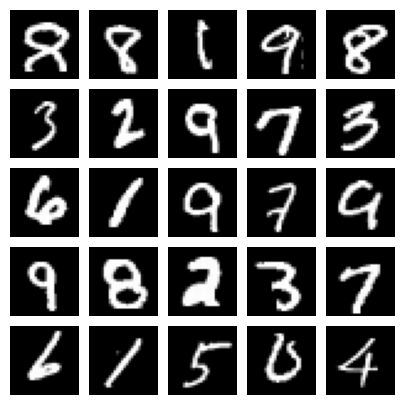

In [9]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [10]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [11]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [12]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [13]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, -1).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  177.74278912119158
	Epoch 2 	Average Loss:  156.31056643885643
	Epoch 3 	Average Loss:  152.3496280584829
	Epoch 4 	Average Loss:  150.2221909725845
	Epoch 5 	Average Loss:  148.68393650876462
	Epoch 6 	Average Loss:  147.5490261764399
	Epoch 7 	Average Loss:  146.3478880164858
	Epoch 8 	Average Loss:  145.10958953398895
	Epoch 9 	Average Loss:  144.31361536806136
	Epoch 10 	Average Loss:  143.55746683926336
	Epoch 11 	Average Loss:  142.98938127673728
	Epoch 12 	Average Loss:  142.36446947712332
	Epoch 13 	Average Loss:  141.6937403484975
	Epoch 14 	Average Loss:  141.50939741691883
	Epoch 15 	Average Loss:  141.04822438439066
	Epoch 16 	Average Loss:  140.62883092915274
	Epoch 17 	Average Loss:  140.2177565310674
	Epoch 18 	Average Loss:  139.67241695142945
	Epoch 19 	Average Loss:  139.52786255086602
	Epoch 20 	Average Loss:  139.01906219023894
	Epoch 21 	Average Loss:  138.937803190865
	Epoch 22 	Average Loss:  138.6186634136321
	Epoch 23 	Average Loss:  13

8067247.4365234375

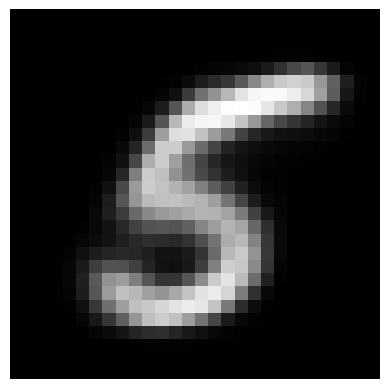

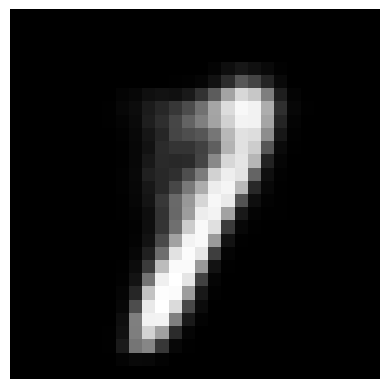

(None, None)

In [14]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [ ]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(model)

NameError: name 'model' is not defined

## Actual

Now let's try to do the same but for the keras png slices data

In [1]:
# Code block
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam

import os
from PIL import Image

We must first recognise that the photos are all greyscale (single channel 0 to 255), and are square with a height and width of 256x256 respectively.

In [2]:
# Import the training images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = 'D:/Files/University/Courses/Year 5/COMP3702/code/lab_2/data/keras_png_slices_data'
train_folder = '/keras_png_slices_train/'
validate_folder = '/keras_png_slices_validate/'
test_folder = '/keras_png_slices_test/'

# Transform to convert PIL image to tensor 
transform = transforms.Compose([
    transforms.ToTensor(),                        # Convert to [0, 1] tensor
])

# Load and transform all images
train_image_tensors = []

def import_photos(folder_name):
    image_tensors = []
    
    for filename in os.listdir(path + folder_name):
        if filename.lower().endswith(('.png')):
            img_path = os.path.join(path + folder_name, filename)
            img = Image.open(img_path).convert('L')  # 'L' mode = grayscale
            tensor = transform(img)  # Shape: [1, 256, 256]
            image_tensors.append(tensor)

    # Convert to big tensor
    dataset = torch.stack(image_tensors)
    
    return dataset

train_dataset = import_photos(train_folder)
validate_dataset = import_photos(validate_folder)
test_dataset = import_photos(test_folder)

print("Datasets imported successfully.")
print(train_dataset.shape) 
print(test_dataset.shape)  
print(validate_dataset.shape) 


Datasets imported successfully.
torch.Size([9664, 1, 256, 256])
torch.Size([544, 1, 256, 256])
torch.Size([1120, 1, 256, 256])


In [ ]:
# As the images are already scaled between 0 and 1, there is no need for further 
# normalization. Instead, just batch the data using DataLoader.

# Load Images
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validate_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

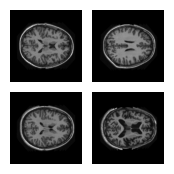

In [ ]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[i, 0, :, :] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
# Now we generate our VAE model - use the example code from the lecture
class CNN_VAE(nn.Module):

    def __init__(self, latent_dim=65536, device=device):
        super(CNN_VAE, self).__init__()

        
        # Encoder with Max Pooling instead of stride
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # (B, 1, 256, 256) -> (B, 32, 256, 256)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),       # (B, 32, 256, 256) -> (B, 32, 128, 128)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (B, 32, 128, 128) -> (B, 64, 128, 128)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),       # (B, 64, 128, 128) -> (B, 64, 64, 64)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (B, 64, 64, 64) -> (B, 128, 64, 64)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),       # (B, 128, 64, 64) -> (B, 128, 32, 32)

            nn.Flatten(),                                 # (B, 128, 32, 32) -> (B, 131072)
            nn.Linear(128*32*32, latent_dim)              # (B, 131072) -> (B, latent_dim)
            )
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*32*32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),               # (B, latent_dim) -> (B, 128, 32, 32)

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),    # (B, 128, 32, 32) -> (B, 64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),     # (B, 64, 64, 64) -> (B, 32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),      # (B, 32, 128, 128) -> (B, 1, 256, 256)
            nn.Sigmoid() #[0, 1] output
            )
     
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [ ]:
autoencoder = CNN_VAE().to(device)
ae_criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=1e-3)

In [ ]:
# Train autoencoder
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Instantiate CNN autoencoder, loss and optimiser
autoencoder = CNN_VAE().to(device)
ae_criterion = nn.MSELoss()
ae_optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# Train autoencoder
num_ae_epochs = 10
n_images = 25
for epoch in range(num_ae_epochs):
    autoencoder.train()
    total_loss = 0

    for images, _ in train_loader:
        images = images.to(device)
        outputs = autoencoder(images)
        loss = ae_criterion(outputs, images)

        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

        total_loss += loss.item() * images.size(0)
    
    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_ae_epochs}], Loss: {avg_loss:.5f}')

    # visualize some reconstructed images
    autoencoder.eval()
    with torch.no_grad():
        image_vis, _ = next(iter(test_loader))
        image_vis = image_vis.to(device)

        recon_images = autoencoder(image_vis)
        images_vis = images_vis.cpu().numpy()
        recon_images = recon_images.cpu().numpy()

    plt.figure(figsize=(2 * n_images, 4))
    for i in range(n_images):
        # Original images
        plt.subplot(2, n_images, i + 1)
        plt.imshow(images_vis[i].[0], cmap='gray')
        plt.axis('off')
        plt.title('Original Images', fontsize=16)

        # Reconstructed images
        plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(recon_images[i][0], cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed Images', fontsize=16)